# Cross correlation function (CCF)
Conda environemnt: `time-series`  
16 Mar 2024

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib.axes import Axes
from matplotlib.ticker import MaxNLocator

from statsmodels.tsa.stattools import ccf
from statsmodels.tsa.seasonal import STL

In [2]:
# Configs
# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize
# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

In [54]:
### Functions
def lag_plot(y: pd.Series, x: pd.Series, lag: int, ax: Axes=None, data_point_size: int=10) -> Axes:
    """Lag plot between target time series (y) and feature time series (x).
    Args:
        y (pd.Series): target time series (e.g. sales).
        x (pd.Series): feature time series (e.g. ad spend).
        lag (int): the amount, we want to lag by.
        ax (Axes, optional): axes object. Defaults to None.
        data_point_size (int, optional): Dot size. Defaults to 10.
    Returns:
        Axes: Lag plot Axes object.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=[5,5])
    ax.scatter(y=y, x=x.shift(periods=lag), s=data_point_size)
    ax.set_ylabel("$y_t$")
    ax.set_xlabel(f"$x_{{t-{lag}}}$")
    return ax

def plot_ccf(y: pd.Series, x: pd.Series, lags: int) -> Axes:
    """Plot the Cross Correlation Function (CCF) and its confidence interval (CI)
    Args:
        y (pd.Series): target time series (e.g. sales).
        x (pd.Series): feature time series (e.g. ad spend).
        lags (int): the amount, we want to lag by.
    Returns:
        Axes: CCF plot.
    """
    # Compute CCF and confidence interval
    cross_corrs = ccf(x, y)
    ci = 2 / np.sqrt(len(y))
    # Plot
    fig, ax = plt.subplots(figsize=[10, 5])
    ax.stem(range(0, lags + 1), cross_corrs[: lags + 1]) # We care only of the second column from ccf output.
    ax.fill_between(range(0, lags + 1), ci, y2=-ci, alpha=0.2)
    ax.set_title("Cross-correlation")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    return ax

## 1) Compute CCF for a white noise time series
$$y_t = \epsilon_t$$ 
$$x_t = \alpha_t$$ 

where $$\epsilon_{t}, \alpha_{t}  \sim  N(mean, std)$$

In [10]:
# Let's create 2 white-noise time series 
SEED = 0
np.random.seed(SEED)
time_series_lenght = 1000

# Target and feature time-series
y = np.random.normal(loc=0, scale=1, size=time_series_lenght)
x = np.random.normal(loc=0, scale=1, size=time_series_lenght)
# Create time-seriesi indexes
ts = pd.date_range(start="2000-01-01", periods=time_series_lenght, freq="D")
# Final time-series
df = pd.DataFrame(data={"y": y, "x": x}, index=ts)
df.head()

,y,x
2000-01-01,1.7641,0.5560
2000-01-02,0.4002,0.8925
2000-01-03,0.9787,-0.4223
2000-01-04,2.2409,0.1047
2000-01-05,1.8676,0.2281


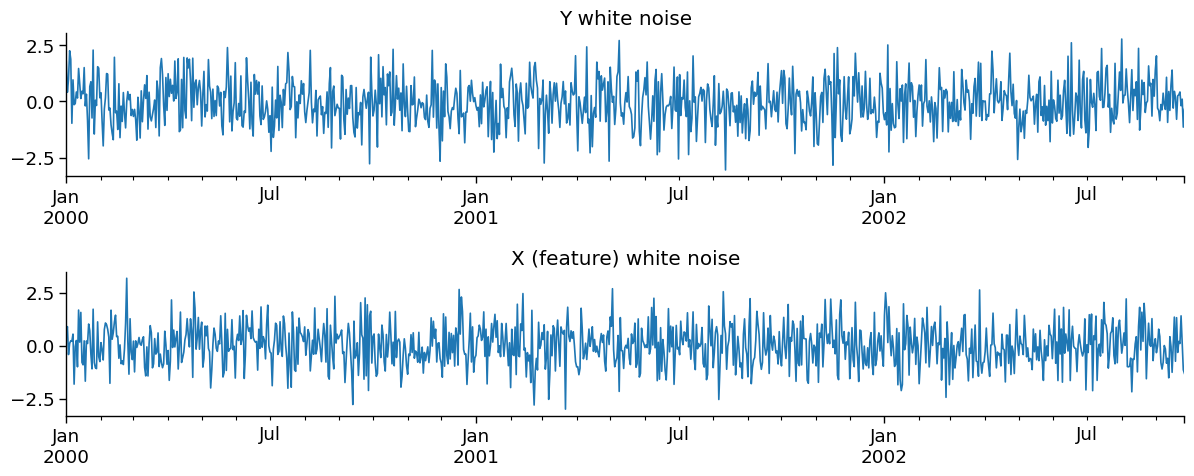

In [23]:
fig, ax = plt.subplots(nrows=2, figsize=[12,5])

df["y"].plot(ax=ax[0])
df["x"].plot(ax=ax[1])

ax[0].set_title("Y white noise")
ax[1].set_title("X (feature) white noise")

plt.tight_layout()

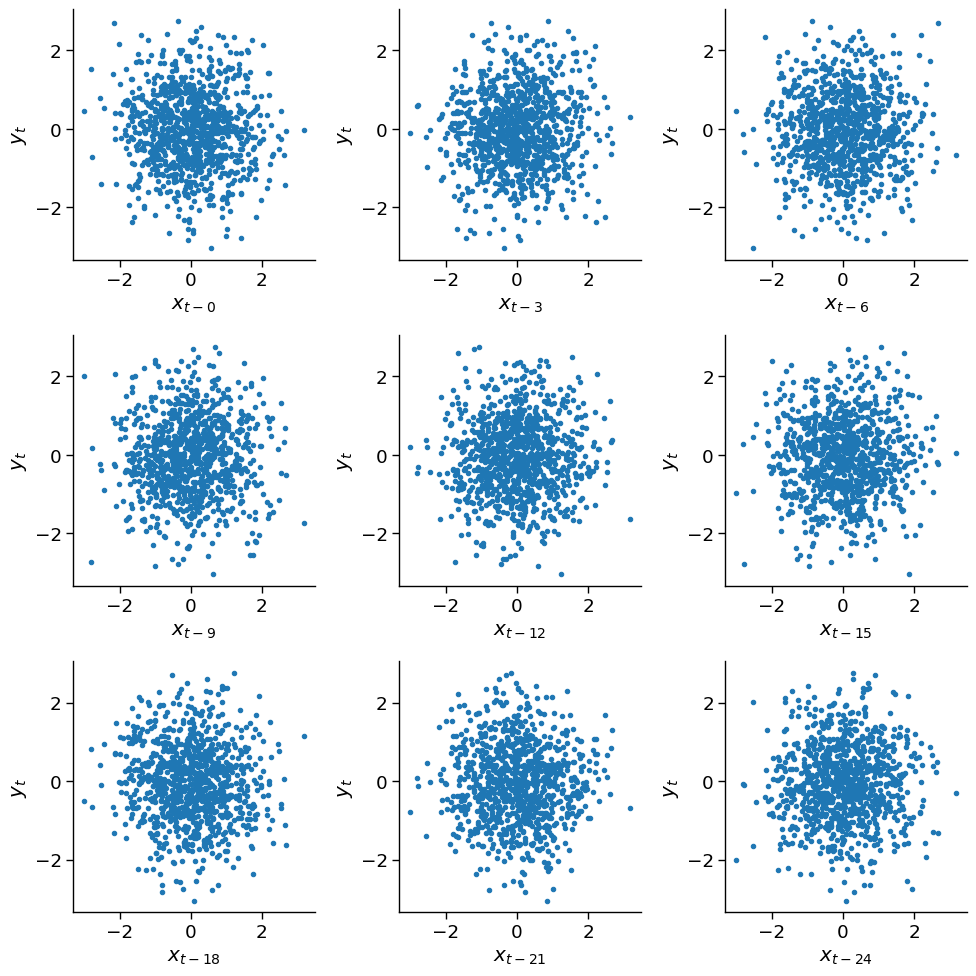

In [49]:
# Plot lag plots
fig, ax = plt.subplots(3,3, figsize=[10,10])
axs = ax.flatten()
for i, lag in enumerate(range(0, 27, 3)): #e.g. 0,3,6,9,12,..,24
    ax = lag_plot(y=df["y"], x=df["x"], lag=lag, ax=axs[i])
plt.tight_layout()

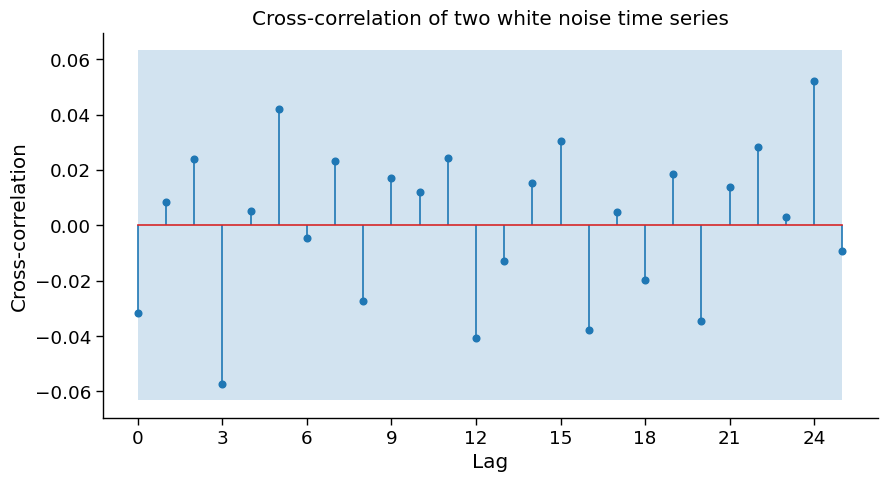

In [57]:
# Plot CCF
ax = plot_ccf(y=df["y"], x= df["x"], lags=25)
ax.set_title("Cross-correlation of two white noise time series")
ax.set_ylabel("Cross-correlation")
ax.set_xlabel("Lag")

plt.show()

## 2) CCF: AR(1) time series

In [64]:
# Initial parameters
num_timesteps = 1000  # Length of time series we want
np.random.seed(0)  # Ensures we generate the same random numbers every time
p = 10
phi_yx = 3
phi_xx = 0.9
ts = pd.date_range(start="2000-01-01", periods=num_timesteps, freq="D")

# Generate time series
x = np.zeros(num_timesteps)
y = np.zeros(num_timesteps)

# Generate x
for t in range(1, num_timesteps):
    noise = np.random.normal()
    x[t] = phi_xx * x[t - 1] + noise

# Generate y
for t in range(p, num_timesteps):
    noise = np.random.normal()
    y[t] = phi_yx * x[t - p] + noise

df = pd.DataFrame(data={"y": y[p:], "x": x[p:]}, index=ts[p:])
df.head()

,y,x
2000-01-11,-0.3581,3.8640
2000-01-12,5.8481,3.6217
2000-01-13,6.8559,4.7138
2000-01-14,7.8810,5.0034
2000-01-15,14.3004,4.6248


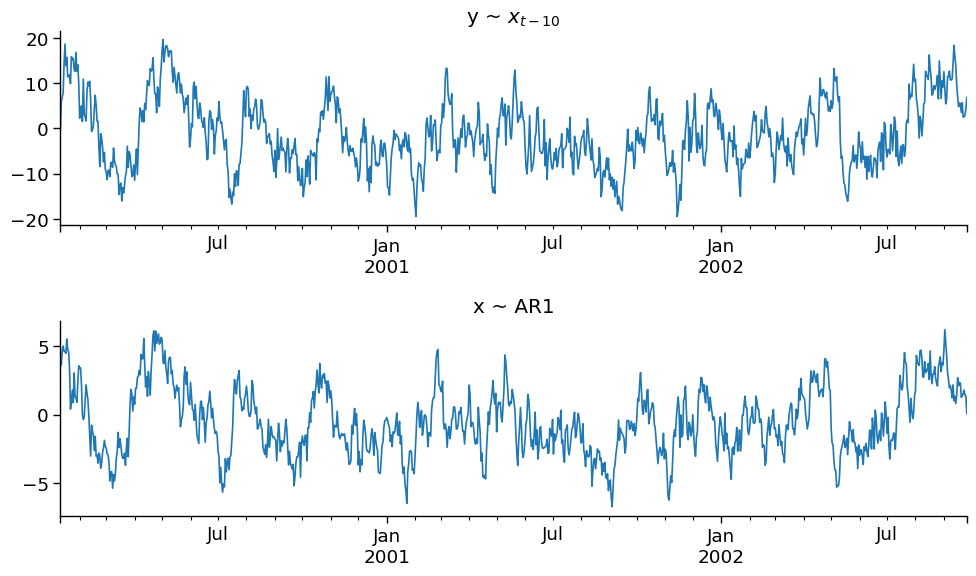

In [65]:
# Plot the two time series
fig, ax = plt.subplots(nrows=2, figsize=[10, 6])
df["y"].plot(y=["y"], ax=ax[0])
df["x"].plot(y=["x"], ax=ax[1])
ax[0].set_title(f"y ~ $x_{{t-{p}}}$")
ax[1].set_title("x ~ AR1")

plt.tight_layout()

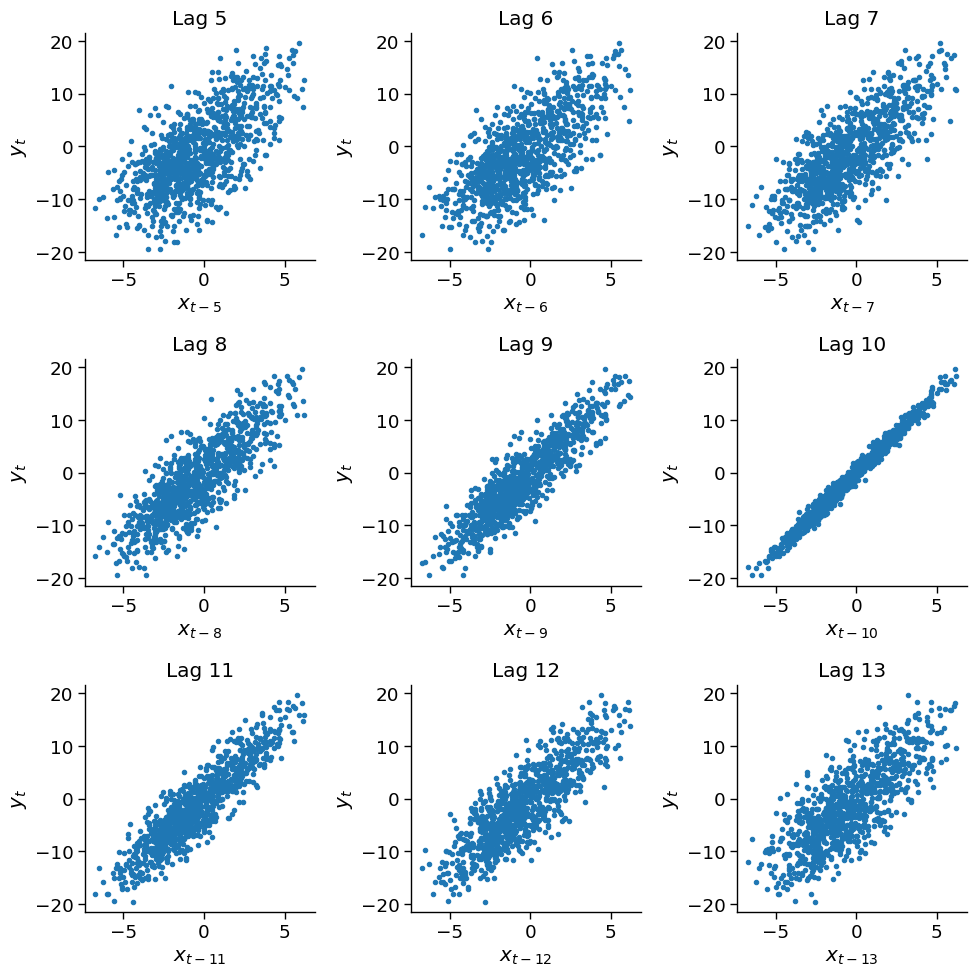

In [66]:
# Plot a lag plot
fig, ax = plt.subplots(3, 3, figsize=[10, 10])
axs = ax.flatten()
for ix, lag in enumerate(range(max(0, p - 5), p + 4)):
    ax = lag_plot(y=df["y"], x=df["x"], lag=lag, ax=axs[ix])
    ax.set_title(f"Lag {lag}")
plt.tight_layout()

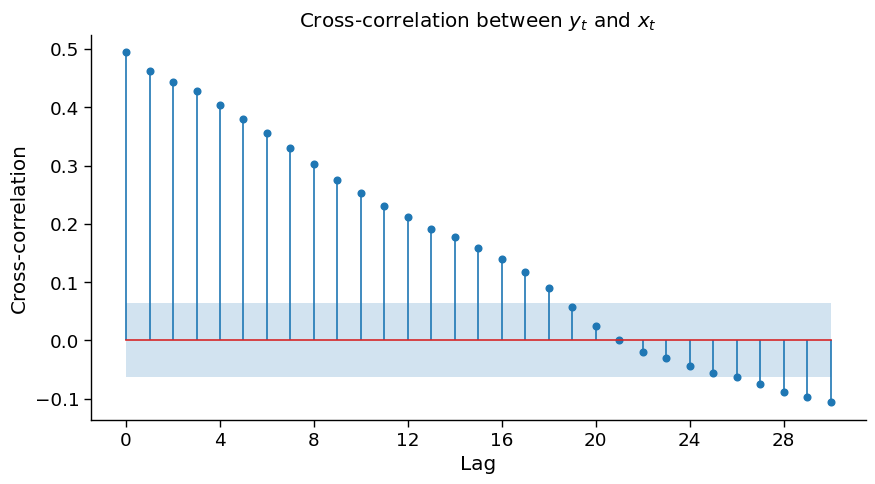

In [67]:
ax = plot_ccf(df["y"], df["x"], lags=30)
ax.set_title("Cross-correlation between $y_t$ and $x_t$")
ax.set_ylabel("Cross-correlation")
ax.set_xlabel("Lag")

plt.show()

## 3) Time series with trend and seasonality

In [69]:
df_air_passengers = pd.read_csv("../Datasets/example_air_passengers.csv", nrows=120)
df_retail_sales = pd.read_csv("../Datasets/example_retail_sales.csv", nrows=120)

df = pd.DataFrame(data={"air": df_air_passengers["y"], "retail": df_retail_sales["y"]})
df

,air,retail
0,112,146376
1,118,147079
2,132,159336
3,129,163669
4,121,170068
...,...,...
115,505,294763
116,404,261924
117,359,291596
118,310,287537


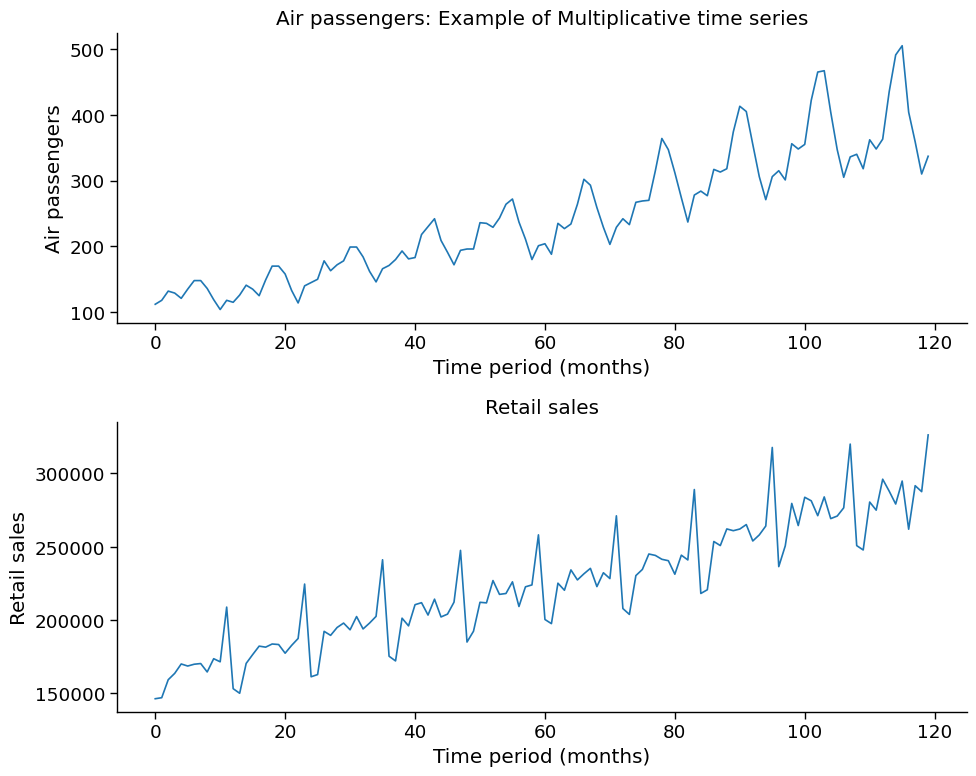

In [71]:
# Plot the two time series
fig, ax = plt.subplots(nrows=2, figsize=[10, 8])
df["air"].plot(y=["air"], ax=ax[0])
ax[0].set_xlabel("Time period (months)")
ax[0].set_ylabel("Air passengers")
ax[0].set_title("Air passengers: Example of Multiplicative time series")

df["retail"].plot(y=["retail"], ax=ax[1])
ax[1].set_xlabel("Time period (months)")
ax[1].set_ylabel("Retail sales")
ax[1].set_title("Retail sales")

plt.tight_layout()